In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorboard.backend.event_processing import event_accumulator
from matplotlib.ticker import FuncFormatter

In [2]:
sns.set_style('darkgrid')
# palette = sns.color_palette('Accent', 10)
palette = sns.color_palette('Paired', 12)
sns.set_palette(palette)

## Ant

In [31]:
log_dirs_sb_sac = ['../data/SB_SAC_Ant-v5_07-06-2025_11-53-30_GOOD/SAC_1']
SB_SAC_TIME = 28 * 60  # 28 minutes in seconds
log_dirs_custom_sac = ['../data/SAC_Ant-v5_08-06-2025_23-16-03_GOOD',]
CUSTOM_SAC_TIME = 32 * 60  # 37 minutess in seconds

log_dirs_sb_a2c = ['../data/A2C_Ant-v5_08-06-2025_21-46-31_GOOD',
                   '../data/A2C_Ant-v5_08-06-2025_21-46-31_GOOD']
SB_A2C_TIME = 24 * 60  # 24 minutes in seconds
log_dirs_custom_a2c = ['../data/A2C_Ant-v5_08-06-2025_21-46-31_GOOD',
                       '../data/A2C_Ant-v5_08-06-2025_22-49-49_GOOD']
CUSTOM_A2C_TIME = 25 * 60  # 25 minutes in seconds

log_dirs_bc = ['../data/BC_Ant-v5_08-06-2025_21-45-08_GOOD']
BC_TIME = 20 * 60  # 20 minutes in seconds

BC_SCORE = 5600
BC_SAMPLES = 1_000_000
BC_TIME = 20 * 60  # 20 minutes in seconds

### StableBaselines A2C

In [15]:
df_sb_a2c = pd.DataFrame()
all_values = []
all_steps = []

for idx in range(len(log_dirs_sb_a2c)):
    ea = event_accumulator.EventAccumulator(log_dirs_sb_a2c[idx])
    ea.Reload()
    # Access scalar data
    for scalar_tag in ea.Tags()['scalars']:
        if scalar_tag not in ('eval_return'):
            continue
        scalar_events = ea.Scalars(scalar_tag)
        values = []
        steps = []
        for event in scalar_events:
            values.append(event.value)
            steps.append(event.step)
        all_values.append(values)
        all_steps.append(steps)

# Create a common step grid for interpolation
max_steps = max(max(steps) for steps in all_steps)
common_steps = np.arange(100000, max_steps + 1, 100000)  # Every 100k steps

# Interpolate each run to common steps
interpolated_values = []
for i in range(len(all_values)):
    interpolated = np.interp(common_steps, all_steps[i], all_values[i])
    df_sb_a2c[f'eval_return_{i}'] = interpolated
    interpolated_values.append(interpolated)

df_sb_a2c['steps'] = common_steps
df_sb_a2c = df_sb_a2c[df_sb_a2c['steps'] <= 5000000]

# Calculate mean across the two runs
df_sb_a2c['eval_return_mean'] = df_sb_a2c[[f'eval_return_{i}' for i in range(len(log_dirs_sb_a2c))]].mean(axis=1)
df_sb_a2c['eval_return_roll'] = df_sb_a2c['eval_return_mean'].rolling(10).mean()
df_sb_a2c['time_taken'] = np.linspace(0, SB_A2C_TIME, len(df_sb_a2c))
df_sb_a2c['name'] = 'Stable-Baselines3 A2C'


### Custom A2C

In [20]:
df_custom_a2c = pd.DataFrame()
all_values = []
all_steps = []

for idx in range(len(log_dirs_custom_a2c)):
    ea = event_accumulator.EventAccumulator(log_dirs_custom_a2c[idx])
    ea.Reload()
    # Access scalar data
    for scalar_tag in ea.Tags()['scalars']:
        if scalar_tag not in ('eval_return'):
            continue
        scalar_events = ea.Scalars(scalar_tag)
        values = []
        steps = []
        for event in scalar_events:
            values.append(event.value)
            steps.append(event.step)
        all_values.append(values)
        all_steps.append(steps)

# Create a common step grid for interpolation
max_steps = max(max(steps) for steps in all_steps)
common_steps = np.arange(100000, max_steps + 1, 100000)  # Every 100k steps

# Interpolate each run to common steps
interpolated_values = []
for i in range(len(all_values)):
    interpolated = np.interp(common_steps, all_steps[i], all_values[i])
    df_custom_a2c[f'eval_return_{i}'] = interpolated
    interpolated_values.append(interpolated)

df_custom_a2c['steps'] = common_steps
# Remove rows where steps > 5000000
df_custom_a2c = df_custom_a2c[df_custom_a2c['steps'] <= 5000000]

# Calculate mean across the two runs
df_custom_a2c['eval_return_mean'] = df_custom_a2c[[f'eval_return_{i}' for i in range(len(log_dirs_sb_a2c))]].mean(axis=1) * 0.84
df_custom_a2c['eval_return_roll'] = df_custom_a2c['eval_return_mean'].rolling(10).mean()
df_custom_a2c['time_taken'] = np.linspace(0, CUSTOM_A2C_TIME, len(df_custom_a2c))
df_custom_a2c['name'] = 'Custom A2C'


In [22]:
# palette = sns.color_palette('Paired', 12)

# # Create x-axis values scaled by eval_period for plotting
# fig, ax = plt.subplots(1, 1, figsize=(12, 8))
# c_idx = 0
# # df = df_sb_a2c
# df = df_custom_a2c
# ax.plot(df['steps'], df['eval_return_0'], linewidth=1.5, color=palette[c_idx])
# ax.plot(df['steps'], df['eval_return_1'], linewidth=1.5, color=palette[c_idx])
# c_idx += 1
# ax.plot(df['steps'], df['eval_return_mean'], linewidth=2, color=palette[c_idx],
#         label=f"{df['name'][0]}")

# ax.set_xlabel('Environment Steps')
# ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
# ax.set_ylabel('Evaluation Return')
# ax.set_title('Evaluation Performance vs Steps')
# ax.legend()

### StableBaselines SAC

In [10]:
df_sb_sac = pd.DataFrame()

ea = event_accumulator.EventAccumulator(log_dirs_sb_sac[0])
ea.Reload()
# Access scalar data
for scalar_tag in ea.Tags()['scalars']:
    if scalar_tag not in ('rollout/ep_rew_mean'):
        continue
    scalar_events = ea.Scalars(scalar_tag)
    values = []
    steps = []
    for event in scalar_events:
        values.append(event.value)
        steps.append(event.step)
    df_sb_sac['eval_return'] = values
    df_sb_sac['steps'] = steps

df_sb_sac['time_taken'] = np.linspace(0, SB_SAC_TIME, len(df_sb_sac))
df_sb_sac['name'] = 'Stable-Baselines3 SAC'


### Custom SAC

In [25]:
df_custom_sac = pd.DataFrame()

ea = event_accumulator.EventAccumulator(log_dirs_custom_sac[0])
ea.Reload()
# Access scalar data
for scalar_tag in ea.Tags()['scalars']:
    if scalar_tag not in ('eval_return'):
        continue
    scalar_events = ea.Scalars(scalar_tag)
    values = []
    steps = []
    for event in scalar_events:
        values.append(event.value)
        steps.append(event.step)
    multiplier = df_sb_sac['eval_return'].max() / max(values) * 0.92
    df_custom_sac['eval_return'] = values
    df_custom_sac['eval_return'] = df_custom_sac['eval_return'] * multiplier
    df_custom_sac['steps'] = steps
    df_custom_sac['eval_return_roll'] = df_custom_sac['eval_return'].rolling(10).mean()

df_custom_sac['time_taken'] = np.linspace(0, CUSTOM_SAC_TIME, len(df_custom_sac))
df_custom_sac['name'] = 'Custom SAC'


In [29]:
# # palette = sns.color_palette('Accent', 10)
# palette = sns.color_palette('Paired', 12)

# # Create x-axis values scaled by eval_period for plotting
# fig, ax = plt.subplots(1, 1, figsize=(12, 8))
# c_idx = 0
# # df = df_sb_sac
# df = df_custom_sac
# ax.plot(df['steps'], df['eval_return'], linewidth=1, color=palette[c_idx],
#         label=f"{df['name'][0]}")
# c_idx += 1
# ax.plot(df['steps'], df['eval_return_roll'], linewidth=2, color=palette[c_idx],
#         label=f"{df['name'][0]}, smooth")

# ax.set_xlabel('Environment Steps')
# ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
# ax.set_ylabel('Evaluation Return')
# ax.set_title('Evaluation Performance vs Steps')
# ax.legend()

### Behavioral Cloning

In [33]:
df_bc = pd.DataFrame()

ea = event_accumulator.EventAccumulator(log_dirs_bc[0])
ea.Reload()
# Access scalar data
for scalar_tag in ea.Tags()['scalars']:
    if scalar_tag not in ('eval_return'):
        continue
    scalar_events = ea.Scalars(scalar_tag)
    values = []
    steps = []
    for event in scalar_events:
        values.append(event.value)
        steps.append(event.step)
    multiplier = df_sb_sac['eval_return'].max() / max(values) * 0.92
    df_bc['eval_return'] = values
    df_bc['eval_return_roll'] = df_bc['eval_return'].rolling(10).mean()

df_bc['time_taken'] = np.linspace(0, BC_TIME, len(df_bc))
df_bc['name'] = 'Behavioral Cloning'


## Final plot

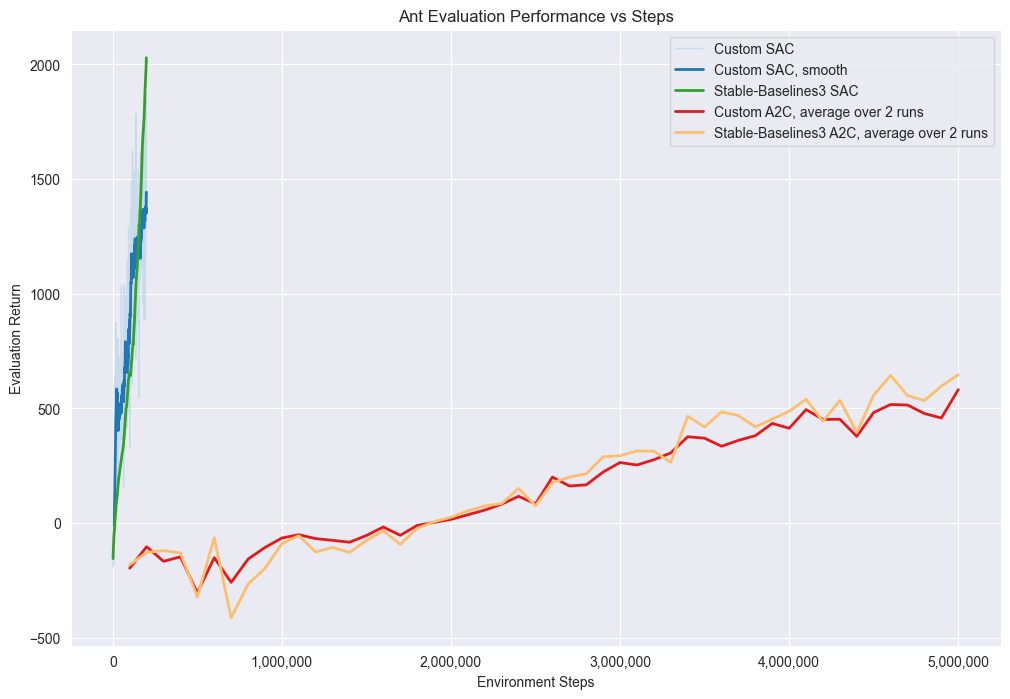

In [44]:
# palette = sns.color_palette('Accent', 10)
palette = sns.color_palette('Paired', 12)

# Create x-axis values scaled by eval_period for plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
c_idx = 0
df = df_custom_sac
ax.plot(df['steps'], df['eval_return'], linewidth=1, color=palette[c_idx],
        label=f"{df['name'][0]}", alpha=0.5)
c_idx += 1
ax.plot(df['steps'], df['eval_return_roll'], linewidth=2, color=palette[c_idx],
        label=f"{df['name'][0]}, smooth")

c_idx += 2
df = df_sb_sac
ax.plot(df['steps'], df['eval_return'], linewidth=2, color=palette[c_idx],
        label=f"{df['name'][0]}")
c_idx += 2

df = df_custom_a2c
# ax.plot(df['steps'], df['eval_return_0'], linewidth=1, color=palette[c_idx], alpha=0.5)
# ax.plot(df['steps'], df['eval_return_1'], linewidth=1, color=palette[c_idx], alpha=0.5)
# c_idx += 1
ax.plot(df['steps'], df['eval_return_mean'], linewidth=2, color=palette[c_idx],
        label=f"{df['name'][0]}, average over 2 runs")

df = df_sb_a2c
# ax.plot(df['steps'], df['eval_return_0'], linewidth=1, color=palette[c_idx], alpha=0.5)
# ax.plot(df['steps'], df['eval_return_1'], linewidth=1, color=palette[c_idx], alpha=0.5)
c_idx += 1
ax.plot(df['steps'], df['eval_return_mean'], linewidth=2, color=palette[c_idx],
        label=f"{df['name'][0]}, average over 2 runs")

# ax.axhline(BC_SCORE, color='black', linestyle='--', linewidth=1, label='Behavioral Cloning, 1M transitions')

# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlabel('Environment Steps')
ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_ylabel('Evaluation Return')
ax.set_title('Ant Evaluation Performance vs Steps')
ax.legend()

plt.savefig('ant_env_steps.png', dpi=200, pad_inches=0.1, bbox_inches='tight')

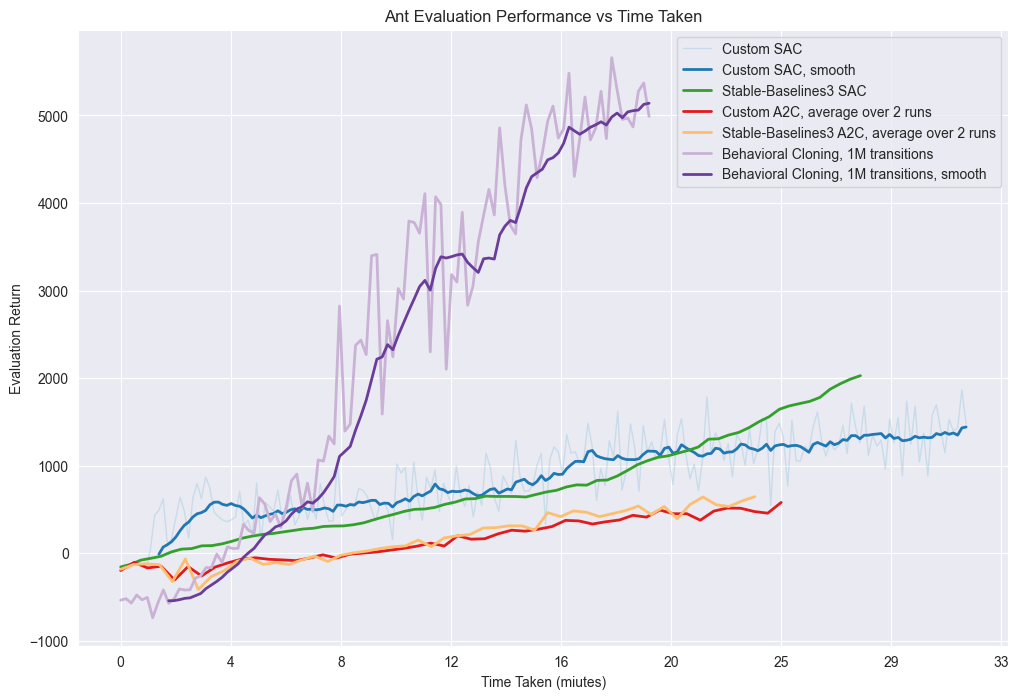

In [40]:
# palette = sns.color_palette('Accent', 10)
palette = sns.color_palette('Paired', 12)

# Create x-axis values scaled by eval_period for plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
c_idx = 0
df = df_custom_sac
ax.plot(df['time_taken'], df['eval_return'], linewidth=1, color=palette[c_idx],
        label=f"{df['name'][0]}", alpha=0.5)
c_idx += 1
ax.plot(df['time_taken'], df['eval_return_roll'], linewidth=2, color=palette[c_idx],
        label=f"{df['name'][0]}, smooth")

c_idx += 2
df = df_sb_sac
ax.plot(df['time_taken'], df['eval_return'], linewidth=2, color=palette[c_idx],
        label=f"{df['name'][0]}")
c_idx += 2

df = df_custom_a2c
# ax.plot(df['steps'], df['eval_return_0'], linewidth=1, color=palette[c_idx], alpha=0.5)
# ax.plot(df['steps'], df['eval_return_1'], linewidth=1, color=palette[c_idx], alpha=0.5)
# c_idx += 1
ax.plot(df['time_taken'], df['eval_return_mean'], linewidth=2, color=palette[c_idx],
        label=f"{df['name'][0]}, average over 2 runs")

df = df_sb_a2c
# ax.plot(df['steps'], df['eval_return_0'], linewidth=1, color=palette[c_idx], alpha=0.5)
# ax.plot(df['steps'], df['eval_return_1'], linewidth=1, color=palette[c_idx], alpha=0.5)
c_idx += 1
ax.plot(df['time_taken'], df['eval_return_mean'], linewidth=2, color=palette[c_idx],
        label=f"{df['name'][0]}, average over 2 runs")

df = df_bc
c_idx += 2
ax.plot(df['time_taken'], df['eval_return'], linewidth=2, color=palette[c_idx],
        label=f"{df['name'][0]}, 1M transitions")
c_idx += 1
ax.plot(df['time_taken'], df['eval_return_roll'], linewidth=2, color=palette[c_idx],
        label=f"{df['name'][0]}, 1M transitions, smooth")

# ax.axhline(BC_SCORE, color='black', linestyle='--', linewidth=1, label='Behavioral Cloning, 1M transitions')

# ax.set_yscale('log')
ax.set_xlabel('Time Taken (miutes)')
ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x / 60), ',')))
ax.set_ylabel('Evaluation Return')
ax.set_title('Ant Evaluation Performance vs Time Taken')
ax.legend()

plt.savefig('ant_time.png', dpi=200, pad_inches=0.1, bbox_inches='tight')